#Mount Google Drive
Required if using google colab which provides free GPUs.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

#Unzip the data files
!unzip -q /content/gdrive/MyDrive/data.zip

Mounted at /content/gdrive/


#Required Libraries Import

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from skimage.io import imshow
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Data Loading and Pre-processing

In [11]:
#Image and Masks directories
input_dir = '/content/images/'
target_dir = '/content/masks/'

#Image Size
IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3

#Get image file names
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ])

#Get mask file names
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ])

#Create empty image and mask arrays
X = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 3), dtype=np.float32)
Y = np.zeros((len(input_img_paths), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)

#Iterate over image and mask files
for i in range(len(input_img_paths)):
    img_path = input_img_paths[i]
    #Load and normalize images
    img = load_img(img_path, grayscale=False,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    img = img_to_array(img)
    X[i] = img.astype('float32') / 255.0
    #Load and normalize masks
    mask_path = target_img_paths[i]
    mask = load_img(mask_path, grayscale=True,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    mask = img_to_array(mask)/255
    Y[i] = mask

#Data training and testing split
#Allocate 80% to training and 20% to testing
train_test_split = int(len(input_img_paths)*0.9)
X_train = X[:train_test_split]
Y_train = Y[:train_test_split]
#Test set
X_test = X[train_test_split:]
Y_test = Y[train_test_split:]

#Data Exploration

Total number of images:  1089
Total number of training images:  980
Total number of test images:  109


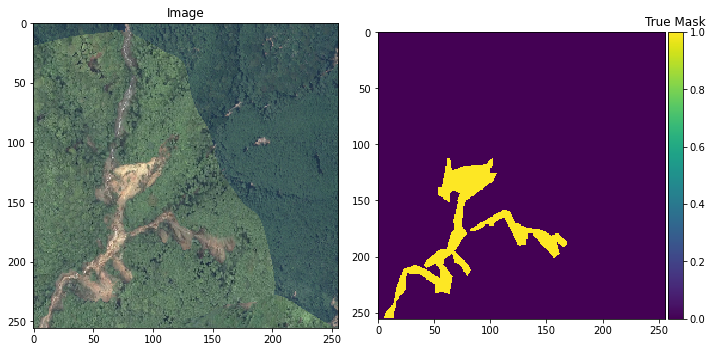

In [12]:
#Info regarding the dataset
print('Total number of images: ', len(input_img_paths))
print('Total number of training images: ', len(X_train))
print('Total number of test images: ', len(X_test))

#Pick randon image in training set
i = random.randint(0, len(X_train))
#Display the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
imshow(X_train[i])
plt.title('Image')
#Display the ground truth mask
plt.subplot(1, 2, 2)
imshow(np.squeeze(Y_train[i]))
plt.title('True Mask')
plt.show()

#U-Net Model Design
If one observes the U-net architecture, it follows a pattern. The encoder of the architecture always contains 2 convolutional layers forming a block which is followed by a maxpooling block. The decoder part of the architecture contains the same pattern by upsamling or transpose convolutional layers.

In [13]:
#Encoder block
def convolutional_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    #Two convolutional layers forming a block
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)    
    #Optional dropout layer to counter overfitting
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    #Maxpooling block    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
    skip_connection = conv
    #Return the layers and skip connections
    return next_layer, skip_connection

#Decoder block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    #Forming transpose convolution blocks
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    #Merging the skip connections
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    return conv

#Final model
def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT,
                           IMG_CHANNELS), n_filters=32, n_classes=2):
    inputs = Input(input_size)
    #Make encoder block
    cblock1 = convolutional_block(inputs, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2*n_filters)
    cblock3 = convolutional_block(cblock2[0], 4*n_filters)
    cblock4 = convolutional_block(cblock3[0], 8*n_filters) 
    cblock5 = convolutional_block(cblock4[0],16*n_filters, max_pooling=None)     
    #Make decoder block
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    #Final output layer
    conv9 = Conv2D(n_classes,1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9) 
    conv10 = Activation('softmax')(conv9)
    #Return the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

#Call the model function
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_classes=2)

#Model summary
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_57[0][0]']              
                                )                                                           

#Model Training

In [14]:
#Hyper-parameters
EPOCHS = 30
Batch_Size = 16
#Model compilation
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#Model training
model_history = unet.fit(X_train, Y_train, validation_split=0.1, batch_size=Batch_Size, epochs=EPOCHS)
#Save the trained model
unet.save('Trained_Model.h5')

Epoch 1/30
56/56 [==============================] - 23s 381ms/step - loss: 0.3741 - accuracy: 0.9199 - val_loss: 0.1459 - val_accuracy: 0.9228
Epoch 2/30
56/56 [==============================] - 19s 337ms/step - loss: 0.1422 - accuracy: 0.9348 - val_loss: 0.1305 - val_accuracy: 0.9353
Epoch 3/30
56/56 [==============================] - 19s 344ms/step - loss: 0.1345 - accuracy: 0.9460 - val_loss: 0.1124 - val_accuracy: 0.9505
Epoch 4/30
56/56 [==============================] - 18s 329ms/step - loss: 0.1263 - accuracy: 0.9467 - val_loss: 0.1102 - val_accuracy: 0.9539
Epoch 5/30
56/56 [==============================] - 18s 328ms/step - loss: 0.1170 - accuracy: 0.9503 - val_loss: 0.1694 - val_accuracy: 0.9250
Epoch 6/30
56/56 [==============================] - 19s 331ms/step - loss: 0.1236 - accuracy: 0.9478 - val_loss: 0.1208 - val_accuracy: 0.9460
Epoch 7/30
56/56 [==============================] - 19s 332ms/step - loss: 0.1128 - accuracy: 0.9524 - val_loss: 0.0938 - val_accuracy: 0.9594

#Model Evaluation

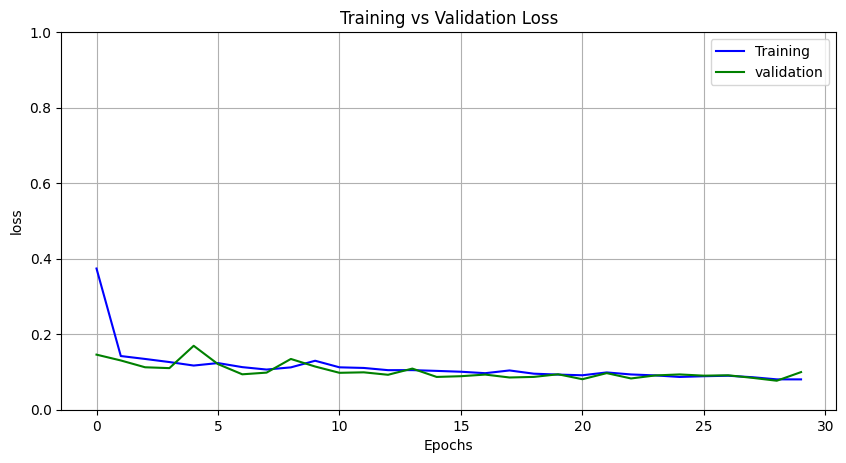

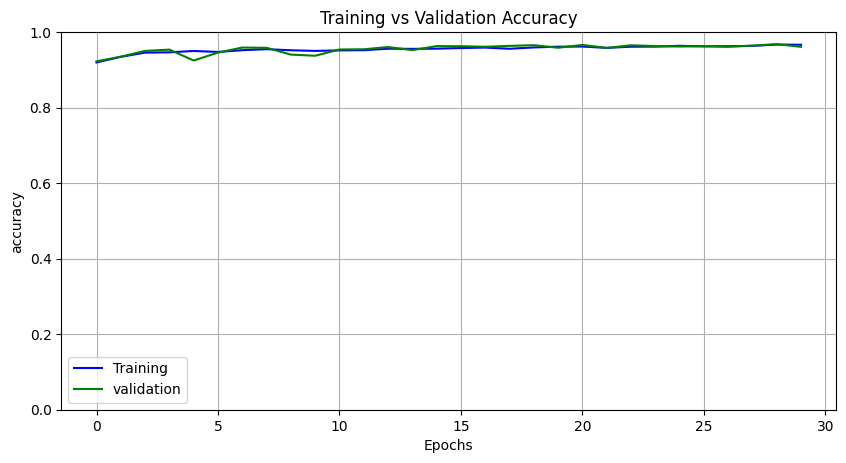

In [15]:
#Plotting model loss and accuracy
def plot_metrics(metric_name, title, ylim=5):
  plt.figure(figsize=(10,5),dpi=100)
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)
  plt.xlabel('Epochs')
  plt.ylabel(metric_name)
  plt.grid()
  plt.legend(['Training', 'validation'])

# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

# Plot the training and validation accuracy
plot_metrics("accuracy", title="Training vs Validation Accuracy", ylim=1)

#Model Intersection over Union (IoU) and Dice Score

In [16]:
# Classes
class_names = ['Background', 'Landslide']

#Compute IoU and Dice score
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  #Iterate over the metrics
  for i in range(2):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    #Calculate IoU
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    #Calculate Dice score
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

# feed the test set to the trained model to get the predicted masks
results = unet.predict(X_test)
predictions = results > 0.5
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(Y_test, results)

# show the IOU for each class
print('The IoU scores for the two classes are given below.')
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

# show the Dice Score for each class
print('The Dice scores for the two classes are given below.')
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

The IoU scores for the two classes are given below.
Background  0.939975470053519 
Landslide   0.7024401297496292 
The Dice scores for the two classes are given below.
Background  0.9690591294212207 
Landslide   0.8252156624811273 


#Visualize Predictions

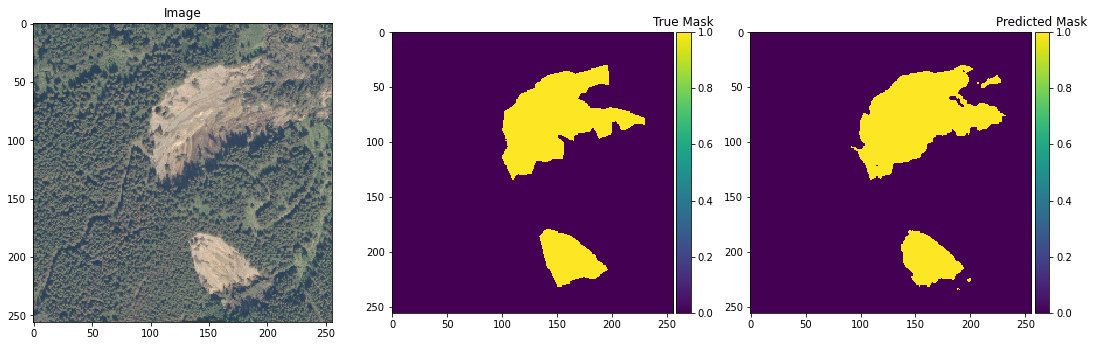

In [17]:
#Pick random image from test set
i = random.randint(0, len(X_test))
predictions = ~predictions
#Display the image
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
imshow(X_test[i])
plt.title('Image')
#Display the true mask
plt.subplot(1,3,2)
imshow(np.squeeze(Y_test[i]))
plt.title('True Mask')
#Display the predicted mask
plt.subplot(1,3,3)
imshow(np.squeeze(predictions[i][:,:,0].astype(int)))
plt.title('Predicted Mask')
plt.show()